In [160]:
import numpy as np
import matplotlib.pyplot as plt

class NoisyLIFNeuron:
    def __init__(self, tau, R, threshold, sigma, dt=0.01):
        self.tau = tau  # Membrane time constant
        self.R = R      # Membrane resistance
        self.threshold = threshold  # Firing threshold
        self.sigma = sigma #Amplitude of the noise (in units of voltage)
        self.dt = dt    # Time step
        self.reset()

    def reset(self):
        self.voltage = 0.0  # Initial membrane potential

    def update(self, I):
        # Membrane potential update using Euler method
        dv = (-(self.voltage) + self.R * I) / self.tau * self.dt + self.sigma*np.sqrt(self.dt)*np.random.normal(0, 1)
        self.voltage += dv
        # Check for spike
        if self.voltage >= self.threshold:
            self.voltage = 0.0  # Reset membrane potential after spike
            return True
        else:
            return False

def simulate_neuron(I, tau, R, threshold, sigma, dt=0.01, duration=10):
    neuron = NoisyLIFNeuron(tau, R, threshold, sigma, dt)
    time = np.arange(0, duration, dt)
    spikes = []
    voltages = []
    for t in time:
        spike = neuron.update(I)
        voltages.append(neuron.voltage)
        if spike:
            spikes.append(t)
    return spikes, voltages


4.98


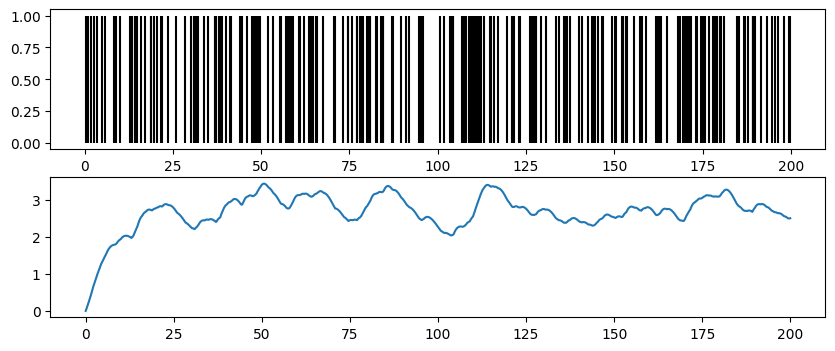

In [175]:
# Simulation parameters
tau = 4 # Membrane time constant (ms)
R = 1    # Membrane resistance
threshold = float('inf')  # Firing threshold
sigma = 0  #NO STOCHASTIC NOISE

dt = 0.01 # Time step (ms)
duration = 200  # Duration of simulation (ms)

I = 1  # Input current (arbitrary units)

lamda_hz = 1000  # Rate of the Poisson process (in Hz)
lambda_ = lamda_hz/1e3  # Rate of the Poisson process (events per unit time (spikes/ms))

w = 0.1 #synaptic weight

# Generate Poisson process
time_points = np.arange(0, duration, dt)
events = np.random.poisson(lambda_ * dt, len(time_points))
events[events > 1] = 1  # Ensure at most one event per timestep

#obtain spike times
t=np.arange(0, duration, dt)
spikes_temp = events*t
spike_times = spikes_temp[spikes_temp != 0]
print(spike_times[5])

#presinaptic input
epsilon=0
for i in range(len(spike_times)):
    epsilon = epsilon + (t-spike_times[i])*np.exp(-(t-spike_times[i])/tau)*np.heaviside(t-spike_times[i],0.5)


spikes, voltages = simulate_neuron(I, tau, R, threshold, sigma, dt, duration)
plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.vlines(spike_times, ymin=0, ymax=1, colors='black', linestyles='-')
plt.subplot(2,1,2)
plt.plot(t, voltages+w*epsilon)
